# TODO

1. Retreive train scaler
     1. inverse_scale(X_tr_scaled)
     2. fit_transform() on train_segments
     3. transform() on validation segments
2. Coordinate file locations and file reads with project.

In [4]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import LeaveOneGroupOut
import pickle

# from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns

In [5]:
def get_model():
#     kwargs = {'iterations':2000, 'loss_function':'MAE', 'boosting_type':'Plain'}
#     selected_model = CatBoostRegressor(**kwargs) 
    kwargs = {"criterion": "mae", "max_depth": 5, "n_estimators": 50, "n_jobs":-1}
    selected_model = RandomForestRegressor(**kwargs)
    
    return selected_model    

In [6]:
DATA_DIR = '../../input'
os.path.join(DATA_DIR,'exp2.csv')

'../../input/exp2.csv'

In [10]:
exp2 = pd.read_csv(os.path.join(DATA_DIR, 'exp2.csv'), index_col=0)
x_tr_scaled = pd.read_csv(os.path.join(DATA_DIR, 'X_tr_scaled.csv'), index_col=0)
y_tr = pd.read_csv(os.path.join(DATA_DIR, 'y_tr.csv'), index_col=0)
segment_df = pd.read_csv(os.path.join(DATA_DIR,'segment_df.csv'), index_col=0)

print(y_tr.shape)
print(x_tr_scaled.shape)
print(segment_df.shape)
segment_df.head()

(4194, 1)
(4194, 138)
(4194, 2)


,quake_id,y_train
0,0,1.430797
1,0,1.391499
2,0,1.353196
3,0,1.313798
4,0,1.274400


In [11]:
def create_quake_df(segment_df):
    quake_gb = segment_df.groupby('quake_id')

    quake_summary = {}
    for quake_id, quake in quake_gb:
        time_min = quake['y_train'].min()
        time_max = quake['y_train'].max()
        quake_duration = time_max-time_min
        num_segments = len(quake)
        segment_idxes = quake.index
        quake_summary[int(quake_id)] = [quake_id, time_min, time_max, quake_duration, num_segments, segment_idxes]

    quake_df = pd.DataFrame(quake_summary).T
    quake_df.columns = ['quake_id', 'time_min','time_max','quake_duration','num_segments','segment_idxes']
    
    return quake_df

def plot_segment_residual(segment_df, target='y_train', set_ax2_ylim=True):
    fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
    ax1.plot(segment_df[target])
    ax1.set_ylabel(target)
    ax1.set_xlabel("Segment #")

    ax2 = ax1.twinx() 
    ax2.plot( segment_df['validation_segment_pred'], color='r')
    ax2.set_ylabel('y_pred')
    
    # Force y_pred to use the same ylim as target
    if set_ax2_ylim:

        ax2.set_ylim(ax1.set_ylim())
    plt.show()

In [13]:
quake_df = create_quake_df(segment_df)
quake_df

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,..."
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,..."
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,..."
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930..."
5,5,0.0276957,8.0545,8.0268,207,"Int64Index([1250, 1251, 1252, 1253, 1254, 1255..."
6,6,0.0334984,7.0473,7.0138,181,"Int64Index([1457, 1458, 1459, 1460, 1461, 1462..."
7,7,0.0102978,16.1032,16.0929,414,"Int64Index([1638, 1639, 1640, 1641, 1642, 1643..."
8,8,0.00649738,7.8769,7.8704,203,"Int64Index([2052, 2053, 2054, 2055, 2056, 2057..."
9,9,0.0206955,9.6052,9.5845,247,"Int64Index([2255, 2256, 2257, 2258, 2259, 2260..."


## Inverse Scale All Training Data

In [14]:
## 1. Retreive scale_params.pickle
## 2. inverse scale x_tr_scaled back to x_tr

# scale_params = pickle.load('scale_params.pickle')
# x_tr = scaler.inverse_transformn(x_tr_scaled)

In [15]:
group_kfold = LeaveOneGroupOut()

fold_splitter = group_kfold.split(x_tr_scaled,y_tr,segment_df['quake_id'])

train_errors = []
validation_errors = []

for quake_id, (train_index, valid_index) in enumerate(fold_splitter):
    if quake_id in [0,16]: # 37 and 48 segments for these quakes
        train_errors.append(np.NaN)
        validation_errors.append(np.NaN)
        continue 

    print('Validation Earthquake:', quake_id,end="   ")

    train_signal, validation_signal = x_tr_scaled.iloc[train_index], x_tr_scaled.iloc[valid_index]
## -- Only using scaled data from entire training at the moment.  Not Robust.
#     # Rescale data using only OOF segments
#     train_signal = scaler.fit_transform(train_signal)
#     validation_signal = scaler.transform(validation_signal)  

    train_quaketime, validation_quaketime = y_tr.iloc[train_index], y_tr.iloc[valid_index]
                
    selected_model = get_model()
    selected_model.fit(train_signal, train_quaketime)
    
    train_error = mean_absolute_error(selected_model.predict(train_signal), train_quaketime)

    validation_segment_pred = selected_model.predict(validation_signal)
    segment_df.loc[valid_index,'validation_segment_pred'] = validation_segment_pred
    
    validation_error = mean_absolute_error(validation_segment_pred, validation_quaketime)

    print('train_error: {0:.2f} \t validation_error: {1:.2f} '.format(train_error, validation_error))
    
    train_errors.append(train_error)
    validation_errors.append(validation_error)

Validation Earthquake: 1   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.91 	 validation_error: 1.57 
Validation Earthquake: 2   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.80 	 validation_error: 2.98 
Validation Earthquake: 3   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.91 	 validation_error: 1.43 
Validation Earthquake: 4   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.86 	 validation_error: 2.24 
Validation Earthquake: 5   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.86 	 validation_error: 2.44 
Validation Earthquake: 6   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.86 	 validation_error: 2.57 
Validation Earthquake: 7   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.69 	 validation_error: 3.85 
Validation Earthquake: 8   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.85 	 validation_error: 2.64 
Validation Earthquake: 9   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.93 	 validation_error: 1.09 
Validation Earthquake: 10   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.91 	 validation_error: 1.45 
Validation Earthquake: 11   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.92 	 validation_error: 1.31 
Validation Earthquake: 12   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.91 	 validation_error: 1.51 
Validation Earthquake: 13   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.90 	 validation_error: 1.76 
Validation Earthquake: 14   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.76 	 validation_error: 3.47 
Validation Earthquake: 15   

/home/ephrim/Projects/Kaggle/LANL_EarthquakePrediction/env/lib/python3.7/site-packages/ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


train_error: 1.90 	 validation_error: 2.27 


Text(0.5, 0, 'quake_id')

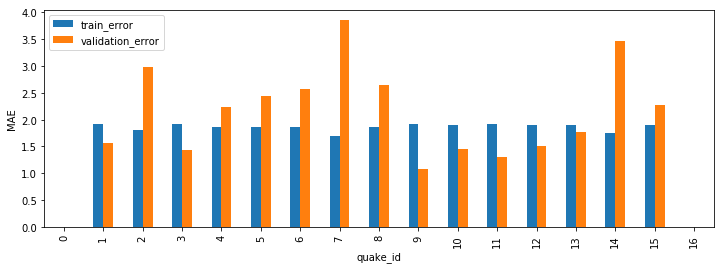

In [16]:
errors_df = pd.DataFrame({'train_error':train_errors, 'validation_error':validation_errors})
errors_df.head()

ax = errors_df[['train_error','validation_error']].plot(kind='bar', figsize=(12,4))
ax.set_ylabel('MAE')
ax.set_xlabel('quake_id')

Excluding predictions from quake_id's 0 and 16 due to the small number of segments.
Quakes 2, 7, and 14 are the longest quakes and the ones with the highest validation error.

In [17]:
quake_df.head()

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,..."
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,..."
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,..."
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930..."


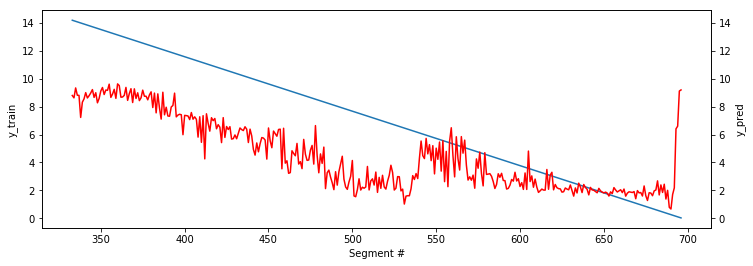

In [18]:
plot_segment_residual(segment_df.loc[quake_df.loc[2,'segment_idxes']])

Something odd is happening on segments it begins predicting large TTF values despite the fact the the quake hasn't occured yet.  It happens in all quake segments

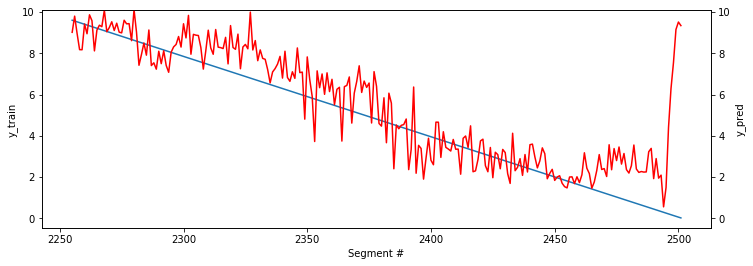

In [19]:
plot_segment_residual(segment_df.loc[quake_df.loc[9,'segment_idxes']])

In [20]:
quake_residuals = pd.concat([quake_df,errors_df], axis=1)
quake_residuals.head()

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes,train_error,validation_error
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8...",NaN,NaN
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,...",1.910492,1.567580
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,...",1.798726,2.984705
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,...",1.913051,1.433774
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930...",1.859719,2.236954


In [21]:
# from sklearn.linear_model import LinearRegression

# q = quake_residuals.dropna()

# reg = LinearRegression()
# reg.fit(q[['quake_duration']], q['validation_error'])

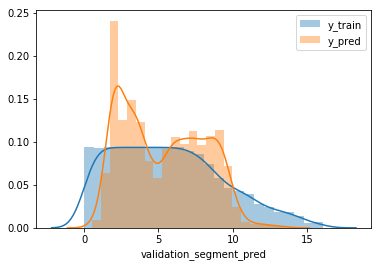

In [22]:
# Drop any rows without 'validation_segment_pred'
pred_hist = segment_df[['y_train','validation_segment_pred']].dropna()

plt.figure()
sns.distplot(pred_hist['y_train'], label='y_train', rug=False)
sns.distplot(pred_hist['validation_segment_pred'], label='y_pred', rug=False)
plt.legend()

There is a conspicuous absence of predictions with low TTF values

#  Predictions and Residuals

One advantage of using a continuous interval of time for the training set is that its possible to average the predictions between contiguous segments, which can be assumed to have similar features.  In order to spot anomalies, I've experimented with large window size and will look for anti-monotonicity in the predictions.

In [23]:
segment_df['validation_segment_residual'] = segment_df['y_train'] - segment_df['validation_segment_pred']

In [24]:
segment_df['validation_segment_residual_2'] = segment_df.rolling(window=2)['validation_segment_residual'].mean()
segment_df['validation_segment_residual_50'] = segment_df.rolling(window=50)['validation_segment_residual'].mean()

In [25]:
segment_df['validation_segment_pred2'] = segment_df.rolling(window=2)['validation_segment_pred'].mean()
segment_df['validation_segment_pred50'] = segment_df.rolling(window=50)['validation_segment_pred'].mean()

## Predictions

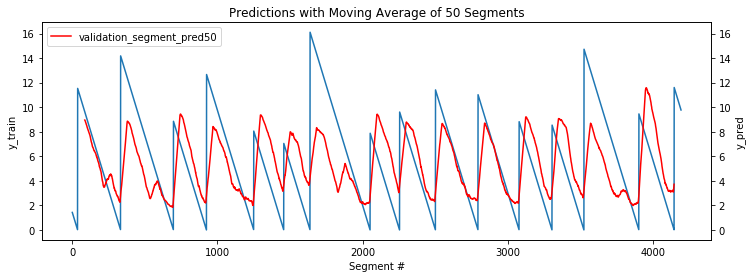

In [45]:
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
ax1.plot(segment_df['y_train'])
ax1.set_ylabel('y_train')
ax1.set_xlabel("Segment #")
ax1.set_title('Predictions with Moving Average of 50 Segments')

# ax2 = ax1.twinx() 
# ax2.plot( segment_df['validation_segment_pred2'], color='#FF8080')
# ax2.set_ylabel('y_pred')
# ax2.set_ylim(ax1.set_ylim())
# plt.legend(loc=1)

ax3 = ax1.twinx() 
ax3.plot( segment_df['validation_segment_pred50'], color='#FF0000')
ax3.set_ylabel('y_pred')
ax3.set_ylim(ax1.set_ylim())

plt.legend(loc=2)
plt.show()

Quakes 1, 2, 7, and 15 (indexed from 0) have a noticeable double sign change on the first derivative of the predicted values. This doesn't pinpoint where the anomalies are occuring, but can be used to identify larger sections of a quake that are adding time back on to the TTF countdown.

## Residuals

Mean Absolute Error is the scoring metric, so we should try plotting the absolute value of the residuals.

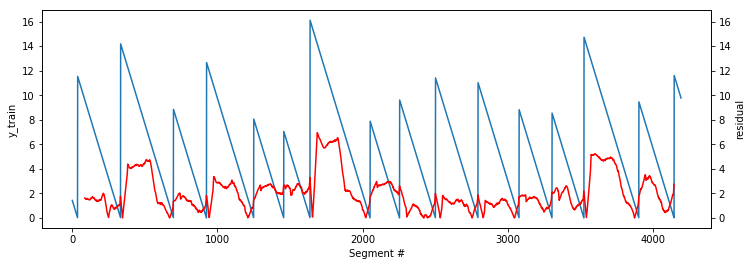

In [46]:
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
ax1.plot(segment_df['y_train'])
ax1.set_ylabel('y_train')
ax1.set_xlabel("Segment #")

ax2 = ax1.twinx() 
ax2.plot( np.abs(segment_df['validation_segment_residual_50']), color='r')
ax2.set_ylabel('residual')

# Force y_pred to use the same ylim as target
# ax1.set_ylim(ax2.set_ylim())
ax2.set_ylim(ax1.set_ylim())
plt.show()

Even if there are slow quakes in the test set, it may be worthwhile to downweight segments from longer quakes when we train or stack our models.

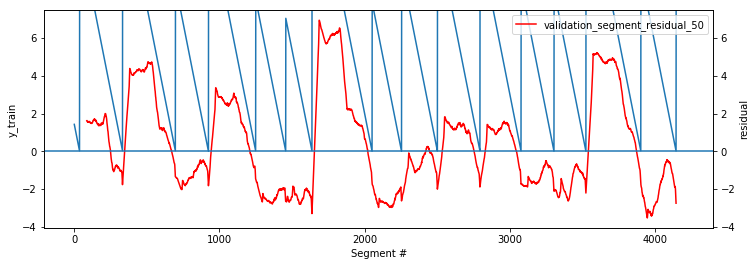

In [47]:
fig, ax1 = plt.subplots(figsize=(12,4), sharex=True, sharey=True)
ax1.plot(segment_df['y_train'])
ax1.set_ylabel('y_train')
ax1.set_xlabel("Segment #")

ax2 = ax1.twinx() 
ax2.plot( segment_df['validation_segment_residual_50'], color='r')
ax2.set_ylabel('residual')

# Force y_pred to use the same ylim as target
ax1.set_ylim(ax2.set_ylim())

plt.axhline(y=0)
plt.legend()
plt.show()

The pattern of underestimating the large TTF values and overestimating the small TTF values becomes more obvious when we keep the sign of the difference between the two. (y_train - y_pred)

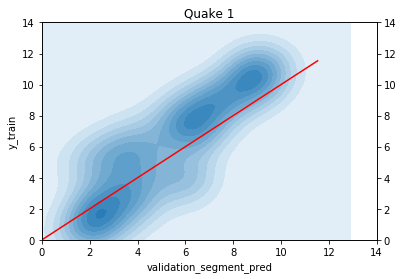

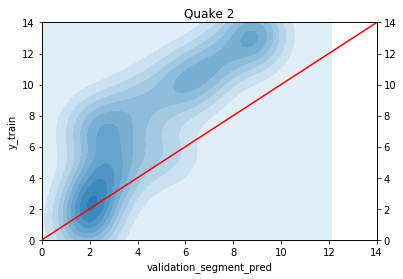

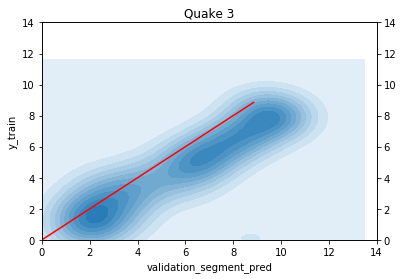

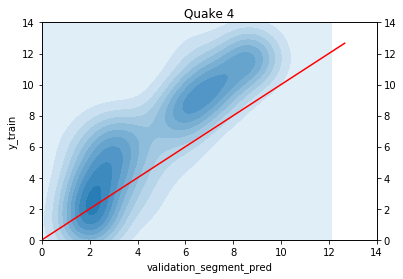

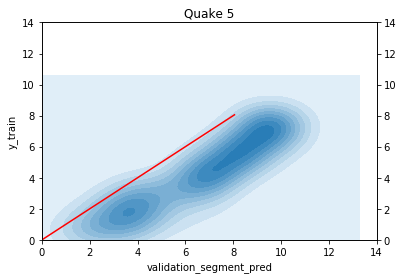

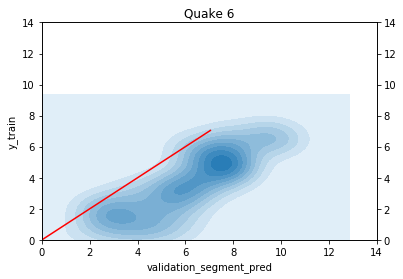

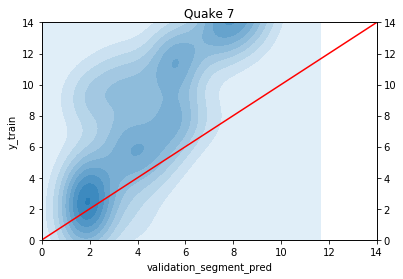

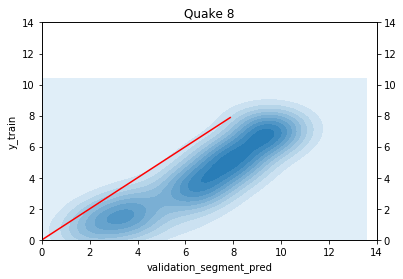

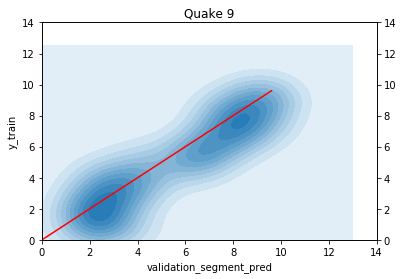

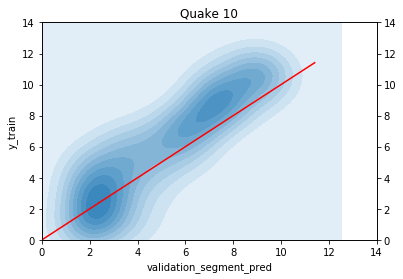

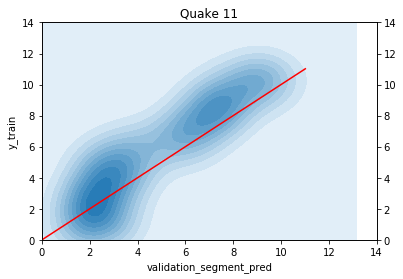

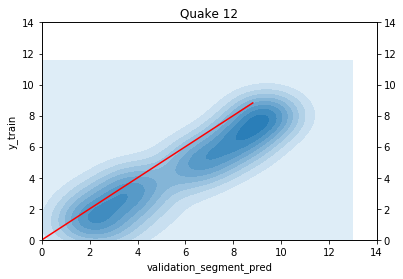

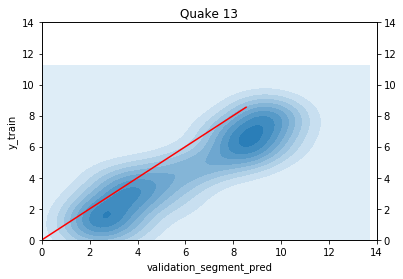

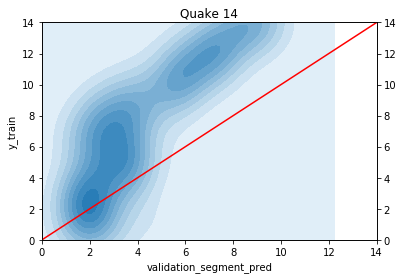

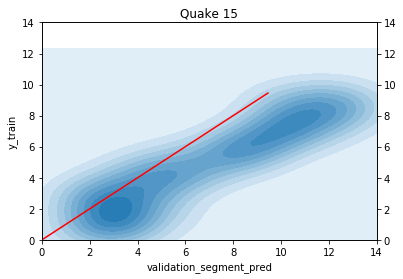

In [60]:
for i in range(1,16):
    sub_segment = segment_df.loc[quake_df.loc[i,'segment_idxes']]
    plt.figure(i)
    ax1 = sns.kdeplot(sub_segment['validation_segment_pred'], sub_segment['y_train'], shade=True)
    ax1.set_ylim(0,14)
    ax1.set_xlim(0,14)
    ax1.set_title('Quake {}'.format(i))
    
    ax2 = ax1.twinx()
    ax2.plot(sub_segment['y_train'],sub_segment['y_train'], color='#FF0000')
    ax2.set_ylim(0,14)
    
## Error Margin
#     ax3 = ax1.twinx()
#     ax3.plot(sub_segment['y_train'],sub_segment['y_train']-1.5, color='#FF8080')
#     ax3.set_ylim(0,14)

#     ax4 = ax1.twinx()
#     ax4.plot(sub_segment['y_train'],sub_segment['y_train']+1.5, color='#FF8080')
#     ax4.set_ylim(0,14)
     
    plt.show()

Perfect predictions would fall on the red line with a 45 degree angle.  MAE is the horizontal distance to the red line (not the length of a 90 degree intersection to the red line)
- Drift is easy to see in this plot as distance along the x-axis to the red line.  Mass to the right of the red line are predictions that overestimated the true TTF. Mass to the left are predictions that understimated the true TTF
- All quakes have a higher density around the 2 TTF range, and then again around the 8 TTF range.  This model does a poor job of capturing values in the middle of a quake.

In [70]:
quake_residuals

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes,train_error,validation_error
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8...",NaN,NaN
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,...",1.910492,1.567580
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,...",1.798726,2.984705
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,...",1.913051,1.433774
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930...",1.859719,2.236954
5,5,0.0276957,8.0545,8.0268,207,"Int64Index([1250, 1251, 1252, 1253, 1254, 1255...",1.863394,2.436170
6,6,0.0334984,7.0473,7.0138,181,"Int64Index([1457, 1458, 1459, 1460, 1461, 1462...",1.861814,2.565449
7,7,0.0102978,16.1032,16.0929,414,"Int64Index([1638, 1639, 1640, 1641, 1642, 1643...",1.687531,3.849912
8,8,0.00649738,7.8769,7.8704,203,"Int64Index([2052, 2053, 2054, 2055, 2056, 2057...",1.852626,2.636091
9,9,0.0206955,9.6052,9.5845,247,"Int64Index([2255, 2256, 2257, 2258, 2259, 2260...",1.925040,1.087780


In [69]:
quake_df

,quake_id,time_min,time_max,quake_duration,num_segments,segment_idxes
0,0,0.0284956,1.4308,1.4023,37,"Int64Index([ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
1,1,0.0357963,11.5301,11.4943,296,"Int64Index([ 37, 38, 39, 40, 41, 42, 43,..."
2,2,0.0337959,14.1774,14.1436,364,"Int64Index([333, 334, 335, 336, 337, 338, 339,..."
3,3,0.00639766,8.8514,8.845,228,"Int64Index([697, 698, 699, 700, 701, 702, 703,..."
4,4,0.0367983,12.6611,12.6243,325,"Int64Index([ 925, 926, 927, 928, 929, 930..."
5,5,0.0276957,8.0545,8.0268,207,"Int64Index([1250, 1251, 1252, 1253, 1254, 1255..."
6,6,0.0334984,7.0473,7.0138,181,"Int64Index([1457, 1458, 1459, 1460, 1461, 1462..."
7,7,0.0102978,16.1032,16.0929,414,"Int64Index([1638, 1639, 1640, 1641, 1642, 1643..."
8,8,0.00649738,7.8769,7.8704,203,"Int64Index([2052, 2053, 2054, 2055, 2056, 2057..."
9,9,0.0206955,9.6052,9.5845,247,"Int64Index([2255, 2256, 2257, 2258, 2259, 2260..."


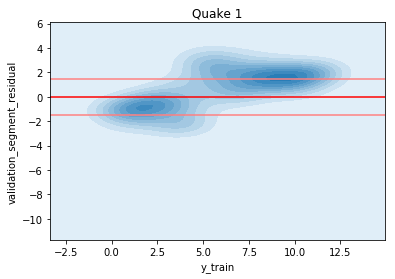

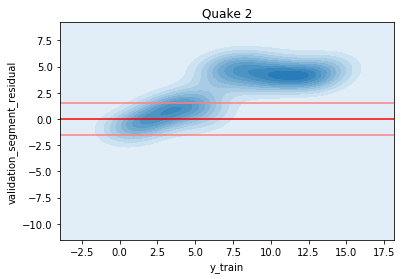

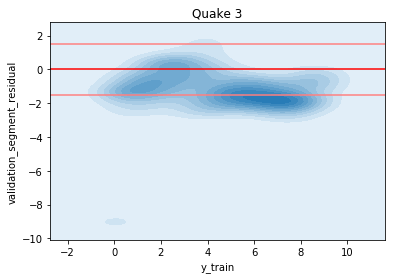

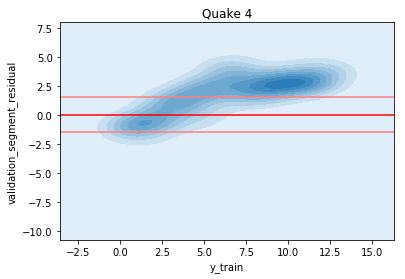

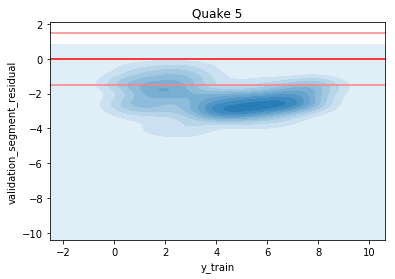

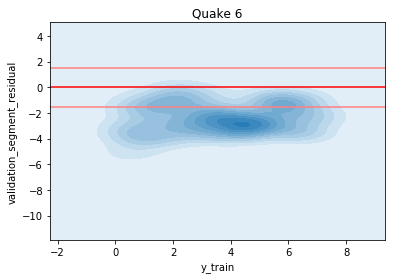

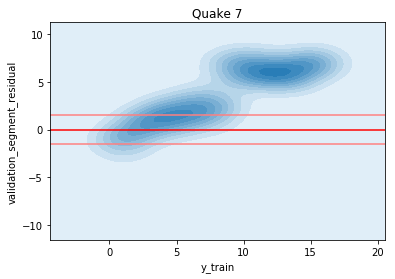

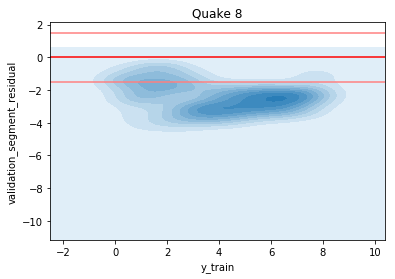

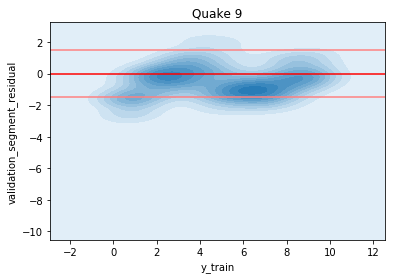

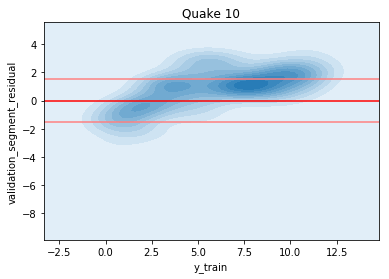

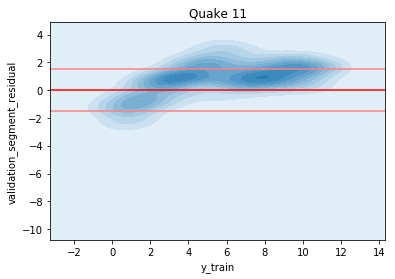

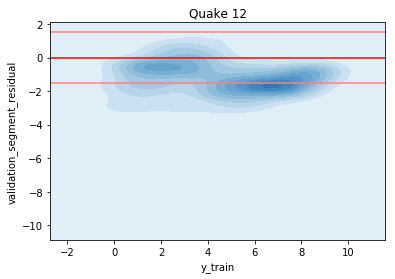

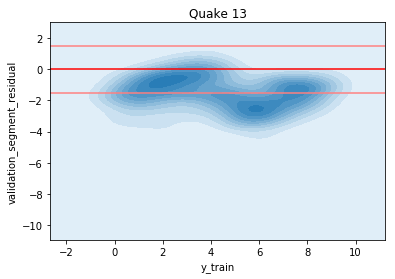

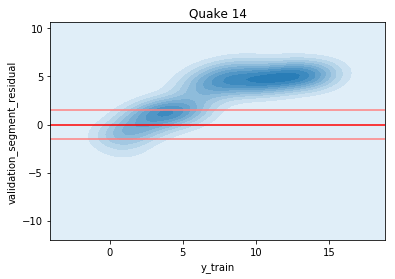

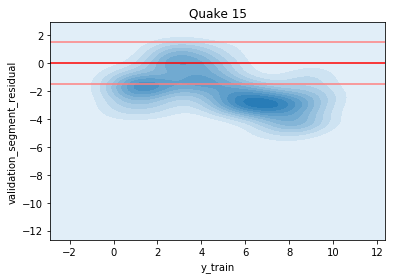

In [77]:
error_margin = 1.5
for i in range(1,16):
    sub_segment = segment_df.loc[quake_df.loc[i,'segment_idxes']]
    plt.figure(i)
    ax1 = sns.kdeplot(sub_segment['y_train'], sub_segment['validation_segment_residual'], shade=True)
    ax1.set_title('Quake {}'.format(i))
    
    plt.axhline(y=0, color='#FF0000')
    plt.axhline(y=error_margin, color='#FF8080')
    plt.axhline(y=error_margin*(-1), color='#FF8080')
    plt.show()

We want the mass to be dense and centered around y=0.

Masses that have a visible trend line (e.g. y!=0 ) are errors in drift.  

Masses that are parallel to y=0 and are outside of our error margin are analogous to quakes that our model interprets as separate and independent quakes.

Something has to be done about quakes 2,7 and 14.